<a href="https://colab.research.google.com/github/novasayat/Twitter-Sentiment-Analysis-/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Description: This is a sentiment analysis program that parses the tweets fetched from Twitter using Python

In [ ]:
# Import Libraries 
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# Load the data
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# Get the data
#log = pd.read_csv("Twitter_API.csv")

In [ ]:
# Twitter API credentials
consumerKey = "HcJUYBlHjlEL5P1D3AZZdRzki"
consumerSecret = "KeU7u2U6PAjsVq4fLzJXJ55sJSpIFVKUGfU1f5f9H2sihUpcjZ"

In [ ]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey,consumerSecret)

# Create API object while passing in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)  # main


In [ ]:
# Lets extract 100 tweets from the twitter user
posts = api.user_timeline(screen_name = "BillGates",count = 200, lang = "en", tweet_mode = "extended")

print("Show the 5 recent tweets: \n")
j = 1
for tweet in posts[0:5]:
  print(str(j)+") "+ tweet.full_text + "\n")
  j+=1



Show the 5 recent tweets: 

1) Congratulations, India, on reaching this tremendous milestone. The collective efforts of the government, R&amp;D community, vaccine manufacturers, and millions of health workers have made this feat possible. @PMOIndia @MoHFW_INDIA https://t.co/cmvQiAfSZG

2) The COVID-19 pandemic reminds us why eradicating malaria is essential. Many of the building blocks we need to fight malaria and prevent the next pandemic are the same. #MosquitoWeek https://t.co/lC9eeVIN3J

3) Mosquitoes are the deadliest animal to humans, but @WMPglobal scientists have discovered how to transform one kind of mosquito into a surprisingly powerful ally: https://t.co/T6H9dVZYP0. #MosquitoWeek🦟 https://t.co/ENiniSLs9z

4) I don’t think any of @ronnychieng’s innovations are ready to bring to market. Luckily, brilliant scientists and engineers around the world have developed hundreds of exciting solutions that will prevent illness and death: https://t.co/x9lELyhV4c https://t.co/asEKuLP3Zm


In [ ]:
# Storing these tweets in a new DataFrame
df = pd.DataFrame([tweet.full_text for tweet in posts], columns = ['Tweets'])

# Show the first 5 rows in the df
df.head(5)

,Tweets
0,"Congratulations, India, on reaching this treme..."
1,The COVID-19 pandemic reminds us why eradicati...
2,"Mosquitoes are the deadliest animal to humans,..."
3,I don’t think any of @ronnychieng’s innovation...
4,I applaud David Vélez and Mariel Reyes’s pledg...


In [ ]:
# Clean the text

#Create a function to clean the tweets
def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)   # removed @mentions
  text = re.sub(r'#', '', text) # removed the '#' symbol
  text = re.sub(r'RT[\s]+', '', text) # removed RT
  text = re.sub(r'https?://+', '', text) # remove the hyperlink

  return text

#cleaning the tweet
df["Tweets"] = df["Tweets"].apply(cleanTxt)

#Show the clean text/tweets
df


,Tweets
0,"Congratulations, India, on reaching this treme..."
1,The COVID-19 pandemic reminds us why eradicati...
2,"Mosquitoes are the deadliest animal to humans,..."
3,I don’t think any of ’s innovations are ready ...
4,I applaud David Vélez and Mariel Reyes’s pledg...
...,...
195,You can listen to a bonus clip that didn’t mak...
196,: Full interview with : t.co/5WtQxlfTm8
197,Nearly forty million people have Alzheimer’s o...
198,"In our first podcast episode, Rashida Jones an..."


In [ ]:
# Create a function to get Subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity   # returns value between (0,1)

# Create a fuvntion to get Polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity       # returns value between (-1,1)

# Create 2 new columns
df['Subjectivity'] = df["Tweets"].apply(getSubjectivity)
df['Polarity'] = df["Tweets"].apply(getPolarity)

df

,Tweets,Subjectivity,Polarity
0,"Congratulations, India, on reaching this treme...",1.000000,0.166667
1,The COVID-19 pandemic reminds us why eradicati...,0.231250,0.125000
2,"Mosquitoes are the deadliest animal to humans,...",0.950000,0.450000
3,I don’t think any of ’s innovations are ready ...,0.650000,0.375000
4,I applaud David Vélez and Mariel Reyes’s pledg...,0.350000,0.025000
...,...,...,...
195,You can listen to a bonus clip that didn’t mak...,0.900000,0.500000
196,: Full interview with : t.co/5WtQxlfTm8,0.550000,0.350000
197,Nearly forty million people have Alzheimer’s o...,0.418182,-0.021212
198,"In our first podcast episode, Rashida Jones an...",0.333333,0.250000


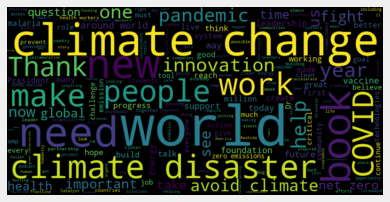

In [ ]:
# Plotting Word Cloud
allWords = "".join( [i for i in df["Tweets"]] )

# Words that you dont want in your WordCloud
stopwords = set(STOPWORDS)
stopwords.update(["will","co", "s", "1","e","t"])

#The below line generates the WordCloud
wordCloud = WordCloud(stopwords = stopwords, background_color = "black",width=800, height=400, random_state= 21, max_font_size= 119).generate(allWords)

#The below line prints thw WordCloud
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show() 

In [ ]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
  if score<0:
    return "Negative"
  elif score == 0:
    return "Nuetral"
  else:
    return "Positive"

# making a new collumn to show the polarity analysis
df["Analysis"] = df["Polarity"].apply(getAnalysis)

df

,Tweets,Subjectivity,Polarity,Analysis
0,"Congratulations, India, on reaching this treme...",1.000000,0.166667,Positive
1,The COVID-19 pandemic reminds us why eradicati...,0.231250,0.125000,Positive
2,"Mosquitoes are the deadliest animal to humans,...",0.950000,0.450000,Positive
3,I don’t think any of ’s innovations are ready ...,0.650000,0.375000,Positive
4,I applaud David Vélez and Mariel Reyes’s pledg...,0.350000,0.025000,Positive
...,...,...,...,...
195,You can listen to a bonus clip that didn’t mak...,0.900000,0.500000,Positive
196,: Full interview with : t.co/5WtQxlfTm8,0.550000,0.350000,Positive
197,Nearly forty million people have Alzheimer’s o...,0.418182,-0.021212,Negative
198,"In our first podcast episode, Rashida Jones an...",0.333333,0.250000,Positive


In [ ]:
# Print all the positive tweets
j = 1
sortedDF = df.sort_values(by = ["Polarity"])
for i in range(0, len(sortedDF)):   #len(df) is to get the number of rows of the dataframe
  if(sortedDF['Analysis'][i] == "Positive"):
    print(str(j)+ ") "+ sortedDF["Tweets"][i])
    print()
    print()
    j+=1


1) Congratulations, India, on reaching this tremendous milestone. The collective efforts of the government, R&amp;D community, vaccine manufacturers, and millions of health workers have made this feat possible.  _INDIA t.co/cmvQiAfSZG


2) The COVID-19 pandemic reminds us why eradicating malaria is essential. Many of the building blocks we need to fight malaria and prevent the next pandemic are the same. MosquitoWeek t.co/lC9eeVIN3J


3) Mosquitoes are the deadliest animal to humans, but  scientists have discovered how to transform one kind of mosquito into a surprisingly powerful ally: t.co/T6H9dVZYP0. MosquitoWeek🦟 t.co/ENiniSLs9z


4) I don’t think any of ’s innovations are ready to bring to market. Luckily, brilliant scientists and engineers around the world have developed hundreds of exciting solutions that will prevent illness and death: t.co/x9lELyhV4c t.co/asEKuLP3Zm


5) I applaud David Vélez and Mariel Reyes’s pledge to dedicate the majority of their wealth to creating opport

In [ ]:
# Print all the negative tweets
j = 1
sortedDF = df.sort_values(by = ["Polarity"], ascending= "False" )
for i in range(0, len(sortedDF)):   #len(df) is to get the number of rows of the dataframe
  if(sortedDF['Analysis'][i] == "Negative"):
    print(str(j)+ ") "+ sortedDF["Tweets"][i])
    print()
    print()
    j+=1

1) Over the years, I’ve shared a stage with a jar of human feces, smelled pit latrine odor, and drunk water made from poop (and convinced  to drink it too). Was it worth it? You bet. Here’s why: t.co/8SJbCuNezD


2) Communities of color have been hit hard by COVID-19. One of the reasons why parts of the medical system often fail Black and brown people is because it’s not designed with them in mind. Dr. Stephaun Wallace wants to change that. t.co/VIaM9385bv


3) Dr. Stephaun Wallace () has spent the last year helping make COVID-19 vaccines work for everybody. Stephaun and his colleagues at  are working to reach the people who are usually left behind. t.co/7wqSeT3DJN


4) It’s deeply unfair that the people who contribute the least to climate change will suffer the worst from its effects: t.co/XciR3lIVzs t.co/Y2do5GhsGx


5) : Over the past few weeks health workers in Ethiopia 🇪🇹, Nigeria 🇳🇬, Sudan 🇸🇩 and the Philippines 🇵🇭 were vaccinated against COVI…


6) For decades, Australian resear

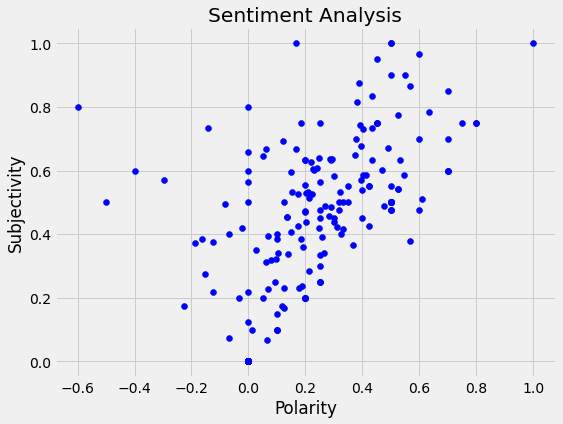

In [ ]:
# Plot the polarity and Subjectivity
plt.figure(figsize=(8,6))
for i in range(0, len(df)):
  plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color = "Blue" )  #plt.scatter(X, Y)

plt.title("Sentiment Analysis")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show()

In [ ]:
# Get the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
print(str(round(  (len(ptweets) / len(df))  *100, 1))+"%")

76.5%


In [ ]:
# Get the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
print(str(round(  (len(ntweets) / len(df))  *100, 1))+"%")

8.5%


In [ ]:
df['Analysis'].value_counts()

Positive    153
Nuetral      30
Negative     17
Name: Analysis, dtype: int64

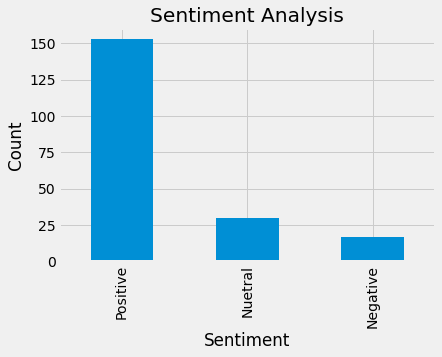

In [ ]:
plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Count")
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()